### Run imports

In [1]:
import yaml
from sqlalchemy.engine.url import URL
from triage.util.db import create_engine
from triage.experiments import MultiCoreExperiment
import logging
import os
from sqlalchemy.event import listens_for
from sqlalchemy.pool import Pool

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2022-12-14 22:09:53 -    INFO Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-12-14 22:09:53 -    INFO NumExpr defaulting to 8 threads.


/data/groups/bills1/dssg_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### Connect to the database

In [2]:
dbfile = ('database.yaml')

with open(dbfile, 'r') as dbf:
    dbconfig = yaml.safe_load(dbf)

print(dbconfig['role'])

db_url = URL(
    'postgres',
    host=dbconfig['host'],
    username=dbconfig['user'],
    database=dbconfig['db'],
    password=dbconfig['pass'],
    port=dbconfig['port']
)
db_engine = create_engine(db_url)

bills1


# Generating PR-k curves used in Final Report
14 December 2022

In [48]:
# Defining helper function to save a single PR-k curve for a single model
def save_PRk(model_group_id):
    global db_engine
    
    # Find model precision at 0-100 percentiles
    precision = pd.read_sql(f"""

    select (cast(substring(e.parameter from '[0-9]+') as integer)) as parameter,
        e.stochastic_value as stochastic_value,
        cast(e.num_positive_labels as decimal(6,1))/cast(e.num_labeled_examples as decimal(6,1)) as base_rate
    from test_results.evaluations e
        left join triage_metadata.models m
            on (e.model_id=m.model_id)
    where metric = 'precision@'
        and m.model_group_id = {model_group_id}
        and e.evaluation_start_time = '2016-12-31 00:00:00.000'
    order by parameter

    """, db_engine)

    # Find model recall at 0-100 percentiles
    recall = pd.read_sql(f"""

    select (cast(substring(e.parameter from '[0-9]+') as integer)) as parameter,
        e.stochastic_value as stochastic_value,
        cast(e.num_positive_labels as decimal(6,1))/cast(e.num_labeled_examples as decimal(6,1)) as base_rate
    from test_results.evaluations e
        left join triage_metadata.models m
            on (e.model_id=m.model_id)
    where metric = 'recall@'
        and m.model_group_id = {model_group_id}
        and e.evaluation_start_time = '2016-12-31 00:00:00.000'
    order by parameter

    """, db_engine)
    
    # Use seaborn's built in aesthetic parameters for paper figures
    sns.set_context('paper')
    
    # Define X and Y values
    x = np.arange(1, 101, 1)
    y_precision = precision['stochastic_value']
    y_recall = recall['stochastic_value']
    y_baserate = recall['base_rate']

    # Instantiate figure
    fig, ax1 = plt.subplots()
    ax1.axvline(x=15, ymin=0, ymax=1, color='orange')  # Visual cue for recall @ 15%

    # Plot data along axes
    ax2 = ax1.twinx()
    ax1.plot(x, y_baserate)
    ax1.plot(x, y_precision, 'b-')
    ax2.plot(x, y_recall, 'r-')

    # Add labels and title
    ax1.set_xlabel('Percent of population')
    ax1.set_ylabel('Precision', color='b')
    ax2.set_ylabel('Recall', color='r')
    ax1.set_ylim(-0.05,1.05)
    ax2.set_ylim(-0.05,1.05)
    plt.title(f'Model Group {model_group_id}')
    
    # Export figure and report function completion
    fig.savefig(f'PRk_curves/_report_Group{model_group_id}', bbox_inches='tight')
    print(f'PR-k curve for model {model_group_id} done.')
    plt.close(fig)


In [49]:
# Our 5 best models
## Not sure why, but model 442 isn't returning any results at the moment
model_groups = ['441', '442', '443', '435', '438']

# Generate PR-k curves for all of these models
for model_group in model_groups:
    save_PRk(model_group)

PR-k curve for model 441 done.
PR-k curve for model 442 done.
PR-k curve for model 443 done.
PR-k curve for model 435 done.
PR-k curve for model 438 done.


# 8 Dec 2022 -- Presentation visuals
## Find the best baseline model

In [9]:
baseline_rank = pd.read_sql('''

select mg.model_type, m.model_id, mg.hyperparameters, avg(stochastic_value) as look_at_this
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
	left join triage_metadata.model_groups mg
		on (mg.model_group_id=m.model_group_id)
where em.experiment_hash = '8f00bc4fd7f00681b116a885813b81de'
	and metric = 'recall@'
	and parameter = '15_pct'
    and evaluation_start_time = '2016-12-31 00:00:00.000'
    and mg.model_type = 'triage.component.catwalk.baselines.rankers.BaselineRankMultiFeature'
group by mg.model_type, m.model_id, mg.hyperparameters
order by look_at_this desc

''', db_engine)

baseline_rank

,model_type,model_id,hyperparameters,look_at_this
0,triage.component.catwalk.baselines.rankers.Bas...,4007,{'rules': [{'feature': 'progress_dummies_entit...,0.547738
1,triage.component.catwalk.baselines.rankers.Bas...,4004,{'rules': [{'feature': 'progress_dummies_entit...,0.510507
2,triage.component.catwalk.baselines.rankers.Bas...,4008,{'rules': [{'feature': 'progress_dummies_entit...,0.472962
3,triage.component.catwalk.baselines.rankers.Bas...,3983,{'rules': [{'feature': 'days_since_entity_id_a...,0.380863
4,triage.component.catwalk.baselines.rankers.Bas...,3980,{'rules': [{'feature': 'sponsors_entity_id_all...,0.361163
5,triage.component.catwalk.baselines.rankers.Bas...,3979,{'rules': [{'feature': 'sponsors_entity_id_all...,0.360642
6,triage.component.catwalk.baselines.rankers.Bas...,3981,{'rules': [{'feature': 'sponsors_entity_id_all...,0.264811
7,triage.component.catwalk.baselines.rankers.Bas...,4011,{'rules': [{'feature': 'sen_majority_sponsor_e...,0.239650
8,triage.component.catwalk.baselines.rankers.Bas...,4012,{'rules': [{'feature': 'either_majority_sponso...,0.210736
9,triage.component.catwalk.baselines.rankers.Bas...,4010,{'rules': [{'feature': 'rep_majority_sponsor_e...,0.200188


In [11]:
baseline_rank.sort_values('look_at_this', ascending=False).head(3)

,model_type,model_id,hyperparameters,look_at_this
0,triage.component.catwalk.baselines.rankers.Bas...,4007,{'rules': [{'feature': 'progress_dummies_entit...,0.547738
1,triage.component.catwalk.baselines.rankers.Bas...,4004,{'rules': [{'feature': 'progress_dummies_entit...,0.510507
2,triage.component.catwalk.baselines.rankers.Bas...,4008,{'rules': [{'feature': 'progress_dummies_entit...,0.472962


In [13]:
baseline_rank.loc[0,'hyperparameters']

{'rules': [{'feature': 'progress_dummies_entity_id_all_bill_status_9_sum',
   'low_value_high_score': False}]}

## Random Forest
### Running queries

In [17]:
precision = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
where metric = 'precision@'
	and e.model_id = 4007
order by parameter
  
""", db_engine)

recall = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
where metric = 'recall@'
	and e.model_id = 4007
order by parameter

""", db_engine)

In [14]:
precision = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = '8f00bc4fd7f00681b116a885813b81de'
	and metric = 'precision@'
	and e.model_id = 4007
order by parameter
  
""", db_engine)

recall = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = '8f00bc4fd7f00681b116a885813b81de'
	and metric = 'recall@'
	and e.model_id = 4007
order by parameter

""", db_engine)

In [18]:
precision

,parameter,stochastic_value,model_id,base_rate
0,1,0.238601,4007,0.041393
1,2,0.224698,4007,0.041393
2,3,0.221387,4007,0.041393
3,4,0.204358,4007,0.041393
4,5,0.192474,4007,0.041393
...,...,...,...,...
95,96,0.036270,4007,0.041393
96,97,0.036044,4007,0.041393
97,98,0.035816,4007,0.041393
98,99,0.035580,4007,0.041393


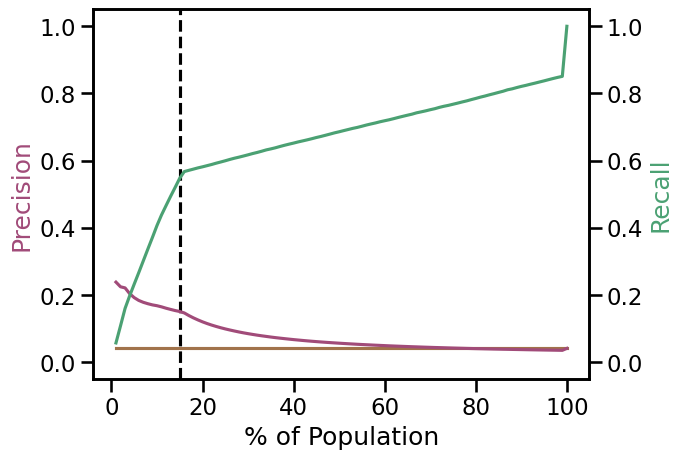

In [22]:
sns.set_context('talk')

x = np.arange(1, 101)
y_precision = precision['stochastic_value']
y_recall = recall['stochastic_value']
y_baserate = recall['base_rate']

fig, ax1 = plt.subplots()
ax1.axvline(x=15, ymin=0, ymax=1, color='black', linestyle='--')

ax2 = ax1.twinx()
ax1.plot(x, y_baserate, '-', color='#a1734b')
ax1.plot(x, y_precision, '-', color='#a14b79')
ax2.plot(x, y_recall, '-', color='#4ba173')

ax1.set_xlabel('% of Population')
ax1.set_ylabel('Precision', color='#a14b79')
ax2.set_ylabel('Recall', color='#4ba173')
ax1.set_ylim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)

#plt.savefig('PRk_curves/{date like 20221018}_{model_type}_{last 6 of exp hash}_{model_id}')
plt.savefig('PRk_curves/20221130_ReferredBaseline_8f00bc_4007.png')
plt.show()

# 30 Nov 2022
## Find the test model

In [3]:
model_rank = pd.read_sql('''

select mg.model_type, m.model_id, avg(stochastic_value) as look_at_this
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
	left join triage_metadata.model_groups mg
		on (mg.model_group_id=m.model_group_id)
where em.experiment_hash = '9952bd9af2a78f3597452aa360e14528'
	and metric = 'precision@'
	and parameter = '15_pct'
    and evaluation_start_time = '2016-12-31 00:00:00.000'
group by mg.model_type, m.model_id
order by look_at_this desc

''', db_engine)

model_rank

,model_type,model_id,look_at_this
0,sklearn.ensemble.RandomForestClassifier,3278,0.231274
1,sklearn.ensemble.RandomForestClassifier,3274,0.230756
2,sklearn.ensemble.RandomForestClassifier,3279,0.230411
3,sklearn.ensemble.RandomForestClassifier,3276,0.230411
4,sklearn.ensemble.RandomForestClassifier,3277,0.230238
...,...,...,...
124,triage.component.catwalk.baselines.rankers.Bas...,2365,0.036941
125,triage.component.catwalk.baselines.rankers.Bas...,2368,0.034231
126,triage.component.catwalk.baselines.rankers.Bas...,2366,0.030848
127,triage.component.catwalk.baselines.rankers.Bas...,2380,0.027080


In [4]:
model_rank.sort_values('look_at_this', ascending=False).groupby(
    'model_type', as_index=False
).head(1)

,model_type,model_id,look_at_this
0,sklearn.ensemble.RandomForestClassifier,3278,0.231274
35,triage.component.catwalk.estimators.classifier...,2392,0.222989
37,sklearn.ensemble.AdaBoostClassifier,3325,0.222299
78,sklearn.tree.DecisionTreeClassifier,2384,0.209941
80,sklearn.neural_network.MLPClassifier,3352,0.201381
91,triage.component.catwalk.baselines.rankers.Bas...,2374,0.151329


## Random Forest
### Running queries

In [9]:
precision_forest = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = '9952bd9af2a78f3597452aa360e14528'
	and metric = 'precision@'
	and e.model_id = 3278
order by parameter
  
""", db_engine)

recall_forest = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = '9952bd9af2a78f3597452aa360e14528'
	and metric = 'recall@'
	and e.model_id = 3278
order by parameter

""", db_engine)

In [10]:
precision_forest

,parameter,stochastic_value,model_id,base_rate
0,1,0.681347,3278,0.041393
1,2,0.581606,3278,0.041393
2,3,0.511226,3278,0.041393
3,4,0.458252,3278,0.041393
4,5,0.418954,3278,0.041393
...,...,...,...,...
95,96,0.043091,3278,0.041393
96,97,0.042646,3278,0.041393
97,98,0.042211,3278,0.041393
98,99,0.041812,3278,0.041393


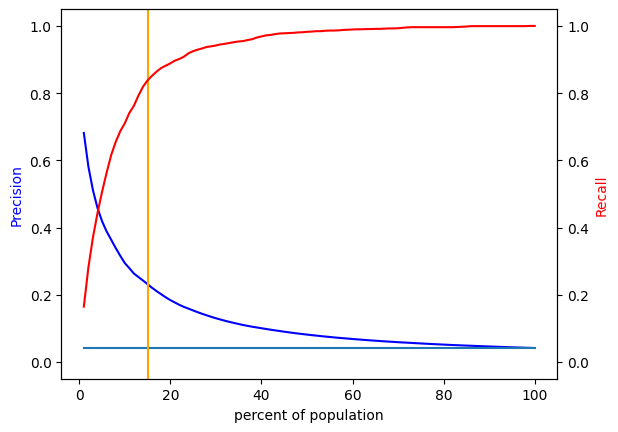

In [11]:
x = np.arange(1, 101, 1)
y_precision_forest = precision_forest['stochastic_value']
y_recall_forest = recall_forest['stochastic_value']
y_baserate_forest = recall_forest['base_rate']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y_precision_forest, 'b-')
ax1.plot(x, y_baserate_forest)
ax2.plot(x, y_recall_forest, 'r-')

ax1.set_xlabel('percent of population')
ax1.set_ylabel('Precision', color='b')
ax2.set_ylabel('Recall', color='r')
ax1.set_ylim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax1.axvline(x=15, ymin=0, ymax=1, color='orange')

#plt.savefig('PRk_curves/{date like 20221018}_{model_type}_{last 6 of exp hash}_{model_id}')
plt.savefig('PRk_curves/20221130_RandomForest_9952bd_3278')
plt.show()

## Logistic Regression
### Running queries

In [15]:
precision_logit = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = '9952bd9af2a78f3597452aa360e14528'
	and metric = 'precision@'
	and e.model_id = 2392
order by parameter
  
""", db_engine)

recall_logit = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = '9952bd9af2a78f3597452aa360e14528'
	and metric = 'recall@'
	and e.model_id = 2392
order by parameter

""", db_engine)

In [16]:
precision_logit

,parameter,stochastic_value,model_id,base_rate
0,1,0.554404,2392,0.041393
1,2,0.477979,2392,0.041393
2,3,0.422280,2392,0.041393
3,4,0.394175,2392,0.041393
4,5,0.378042,2392,0.041393
...,...,...,...,...
95,96,0.043118,2392,0.041393
96,97,0.042673,2392,0.041393
97,98,0.042238,2392,0.041393
98,99,0.041812,2392,0.041393


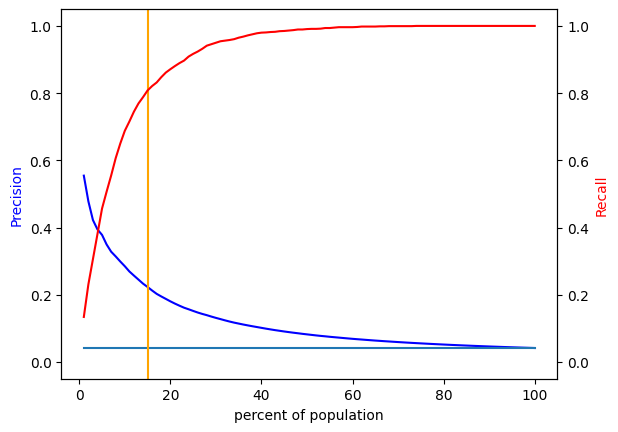

In [17]:
x = np.arange(1, 101, 1)
y_precision_logit = precision_logit['stochastic_value']
y_recall_logit = recall_logit['stochastic_value']
y_baserate_logit = recall_logit['base_rate']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y_precision_logit, 'b-')
ax1.plot(x, y_baserate_logit)
ax2.plot(x, y_recall_logit, 'r-')

ax1.set_xlabel('percent of population')
ax1.set_ylabel('Precision', color='b')
ax2.set_ylabel('Recall', color='r')
ax1.set_ylim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax1.axvline(x=15, ymin=0, ymax=1, color='orange')

#plt.savefig('PRk_curves/{date like 20221018}_{model_type}_{last 6 of exp hash}_{model_id}')
plt.savefig('PRk_curves/20221130_LogisticRegression_9952bd_2392')
plt.show()

# 27 Nov 2022
## Find the test model

In [3]:
model_rank = pd.read_sql('''

select mg.model_type, m.model_id, avg(stochastic_value) as look_at_this
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
	left join triage_metadata.model_groups mg
		on (mg.model_group_id=m.model_group_id)
where em.experiment_hash = '60df9a64527ba26e083e4a729cad66ed'
	and metric = 'recall@'
	and parameter = '15_pct'
    and evaluation_start_time = '2016-12-31 00:00:00.000'
group by mg.model_type, m.model_id
order by look_at_this desc

''', db_engine)

model_rank

,model_type,model_id,look_at_this
0,triage.component.catwalk.estimators.classifier...,1745,0.150144


In [4]:
model_rank.sort_values('look_at_this', ascending=False).groupby(
    'model_type', as_index=False
).head(1)

,model_type,model_id,look_at_this
0,triage.component.catwalk.estimators.classifier...,1745,0.150144


## Catwalk: Scaled Logistic Regression
### Running queries

In [5]:
precision_logit = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = '60df9a64527ba26e083e4a729cad66ed'
	and metric = 'precision@'
	and e.model_id = 1745
order by parameter
  
""", db_engine)

recall_logit = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = '60df9a64527ba26e083e4a729cad66ed'
	and metric = 'recall@'
	and e.model_id = 1745
order by parameter

""", db_engine)

In [6]:
precision_logit

,parameter,stochastic_value,model_id,base_rate
0,1,0.046322,1745,0.045251
1,2,0.046383,1745,0.045251
2,3,0.045581,1745,0.045251
3,4,0.046053,1745,0.045251
4,5,0.045703,1745,0.045251
...,...,...,...,...
95,96,0.045287,1745,0.045251
96,97,0.045276,1745,0.045251
97,98,0.045271,1745,0.045251
98,99,0.045257,1745,0.045251


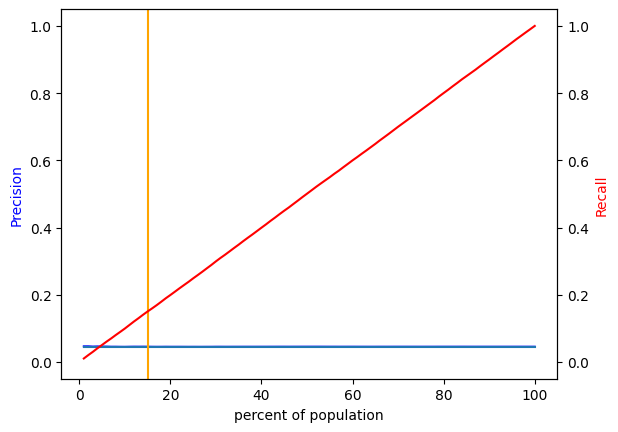

In [7]:
x = np.arange(1, 101, 1)
y_precision_logit = precision_logit['stochastic_value']
y_recall_logit = recall_logit['stochastic_value']
y_baserate_logit = recall_logit['base_rate']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y_precision_logit, 'b-')
ax1.plot(x, y_baserate_logit)
ax2.plot(x, y_recall_logit, 'r-')

ax1.set_xlabel('percent of population')
ax1.set_ylabel('Precision', color='b')
ax2.set_ylabel('Recall', color='r')
ax1.set_ylim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax1.axvline(x=15, ymin=0, ymax=1, color='orange')

#plt.savefig('PRk_curves/{date like 20221018}_{model_type}_{last 6 of exp hash}_{model_id}')
plt.savefig('PRk_curves/20221127_CatwalkLogisticRegression_60df9a_1745')
plt.show()

Oh my god lol that's TERRIBLE! Probably the feature isn't working??

Or maybe the catwalk regression isn't supposed to actually do anything and it's simply a test that the feature doesn't crash triage?

# 17 Nov 2022
## Find the good models!

In [35]:
model_rank = pd.read_sql('''

select mg.model_type, m.model_id, avg(stochastic_value) as look_at_this
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
	left join triage_metadata.model_groups mg
		on (mg.model_group_id=m.model_group_id)
where em.experiment_hash = 'd79d1a38e063e48658a79319b386af5b'
	and metric = 'precision@'
	and parameter = '15_pct'
    and evaluation_start_time = '2016-12-31 00:00:00.000'
group by mg.model_type, m.model_id
order by look_at_this desc

''', db_engine)

model_rank

,model_type,model_id,look_at_this
0,triage.component.catwalk.estimators.classifier...,530,0.217984
1,sklearn.ensemble.RandomForestClassifier,598,0.217639
2,sklearn.ensemble.RandomForestClassifier,596,0.216949
3,sklearn.ensemble.RandomForestClassifier,600,0.216949
4,sklearn.ensemble.RandomForestClassifier,601,0.216603
5,sklearn.ensemble.RandomForestClassifier,599,0.216086
6,sklearn.ensemble.RandomForestClassifier,602,0.215568
7,sklearn.tree.DecisionTreeClassifier,527,0.198539
8,sklearn.tree.DecisionTreeClassifier,528,0.175872
9,sklearn.tree.DecisionTreeClassifier,529,0.167426


In [36]:
model_rank.sort_values('look_at_this', ascending=False).groupby(
    'model_type', as_index=False
).head(1)

,model_type,model_id,look_at_this
0,triage.component.catwalk.estimators.classifier...,530,0.217984
1,sklearn.ensemble.RandomForestClassifier,598,0.217639
7,sklearn.tree.DecisionTreeClassifier,527,0.198539
10,triage.component.catwalk.baselines.rankers.Bas...,521,0.151484


## Scaled Logistic Regression
### Running queries

In [37]:
precision_logit = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = 'd79d1a38e063e48658a79319b386af5b'
	and metric = 'precision@'
	and e.model_id = 530
order by parameter
  
""", db_engine)

recall_logit = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = 'd79d1a38e063e48658a79319b386af5b'
	and metric = 'recall@'
	and e.model_id = 530
order by parameter

""", db_engine)

In [38]:
precision_logit

,parameter,stochastic_value,model_id,base_rate
0,1,0.502591,530,0.041393
1,2,0.419689,530,0.041393
2,3,0.379965,530,0.041393
3,4,0.356634,530,0.041393
4,5,0.335577,530,0.041393
...,...,...,...,...
95,96,0.043118,530,0.041393
96,97,0.042673,530,0.041393
97,98,0.042238,530,0.041393
98,99,0.041812,530,0.041393


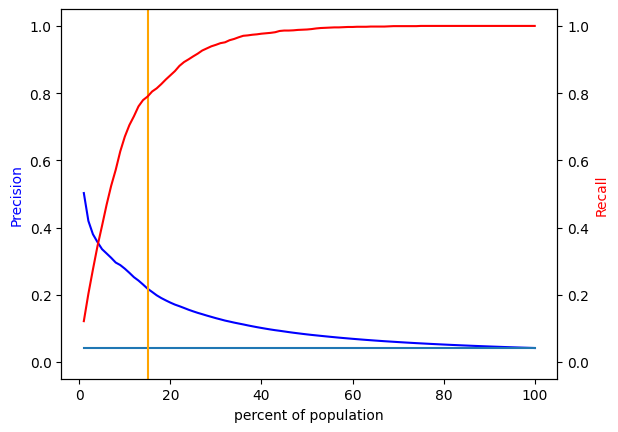

In [39]:
x = np.arange(1, 101, 1)
y_precision_logit = precision_logit['stochastic_value']
y_recall_logit = recall_logit['stochastic_value']
y_baserate_logit = recall_logit['base_rate']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y_precision_logit, 'b-')
ax1.plot(x, y_baserate_logit)
ax2.plot(x, y_recall_logit, 'r-')

ax1.set_xlabel('percent of population')
ax1.set_ylabel('Precision', color='b')
ax2.set_ylabel('Recall', color='r')
ax1.set_ylim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax1.axvline(x=15, ymin=0, ymax=1, color='orange')

#plt.savefig('PRk_curves/{date like 20221018}_{model_type}_{last 6 of exp hash}_{model_id}')
plt.savefig('PRk_curves/20221117_LogisticRegression_86af5b_530')
plt.show()

## Random Forest
### Running queries

In [40]:
precision_forest = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = 'd79d1a38e063e48658a79319b386af5b'
	and metric = 'precision@'
	and e.model_id = 598
order by parameter
  
""", db_engine)

recall_forest = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = 'd79d1a38e063e48658a79319b386af5b'
	and metric = 'recall@'
	and e.model_id = 598
order by parameter

""", db_engine)

In [41]:
recall_forest

,parameter,stochastic_value,model_id,base_rate
0,1,0.185741,598,0.041393
1,2,0.300813,598,0.041393
2,3,0.387742,598,0.041393
3,4,0.455285,598,0.041393
4,5,0.512195,598,0.041393
...,...,...,...,...
95,96,1.000000,598,0.041393
96,97,1.000000,598,0.041393
97,98,1.000000,598,0.041393
98,99,1.000000,598,0.041393


### PR-k curve

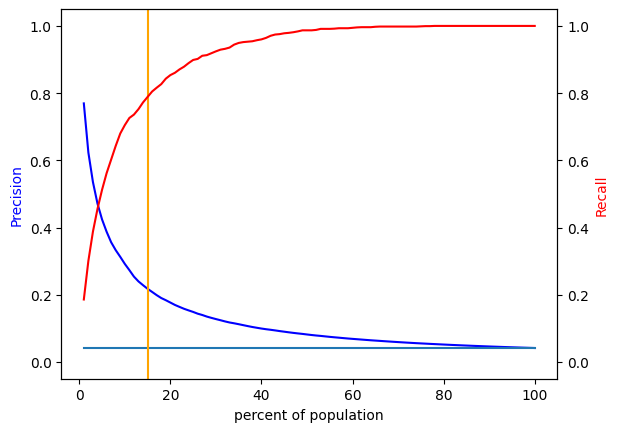

In [42]:
x = np.arange(1, 101)
y_precision = precision_forest['stochastic_value']
y_recall = recall_forest['stochastic_value']
y_baserate = recall_forest['base_rate']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y_precision, 'b-')
ax1.plot(x, y_baserate)
ax2.plot(x, y_recall, 'r-')

ax1.set_xlabel('percent of population')
ax1.set_ylabel('Precision', color='b')
ax2.set_ylabel('Recall', color='r')
ax1.set_ylim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax1.axvline(x=15, ymin=0, ymax=1, color='orange')

#plt.savefig('PRk_curves/{date like 20221018}_{model_type}_{last 6 of exp hash}_{model_id}')
plt.savefig('PRk_curves/20221117_RandomForest_86af5b_598')
plt.show()

## Decision Tree
### Running queries

In [43]:
precision_tree = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = 'd79d1a38e063e48658a79319b386af5b'
	and metric = 'precision@'
	and e.model_id = 527
order by parameter
  
""", db_engine)

recall_tree = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = 'd79d1a38e063e48658a79319b386af5b'
	and metric = 'recall@'
	and e.model_id = 527
order by parameter

""", db_engine)

In [44]:
recall_tree

,parameter,stochastic_value,model_id,base_rate
0,1,0.118783,527,0.041393
1,2,0.240775,527,0.041393
2,3,0.317198,527,0.041393
3,4,0.393016,527,0.041393
4,5,0.455285,527,0.041393
...,...,...,...,...
95,96,0.929581,527,0.041393
96,97,0.930519,527,0.041393
97,98,0.931207,527,0.041393
98,99,0.966792,527,0.041393


### PR-k curve

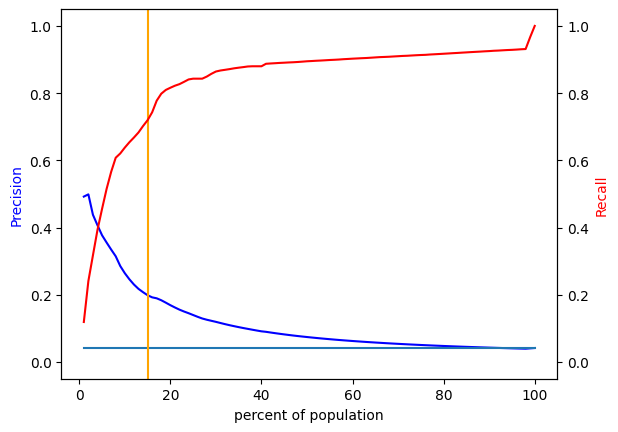

In [45]:
x = np.arange(1, 101)
y_precision = precision_tree['stochastic_value']
y_recall = recall_tree['stochastic_value']
y_baserate = recall_tree['base_rate']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y_precision, 'b-')
ax1.plot(x, y_baserate)
ax2.plot(x, y_recall, 'r-')

ax1.set_xlabel('percent of population')
ax1.set_ylabel('Precision', color='b')
ax2.set_ylabel('Recall', color='r')
ax1.set_ylim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax1.axvline(x=15, ymin=0, ymax=1, color='orange')

#plt.savefig('PRk_curves/{date like 20221018}_{model_type}_{last 6 of exp hash}_{model_id}')
plt.savefig('PRk_curves/20221117_DecisionTree_86af5b_527')
plt.show()

## Baseline (Rank)
### Running queries

In [46]:
precision_b = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = 'd79d1a38e063e48658a79319b386af5b'
	and metric = 'precision@'
	and e.model_id = 521
order by parameter
  
""", db_engine)

recall_b = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = 'd79d1a38e063e48658a79319b386af5b'
	and metric = 'recall@'
	and e.model_id = 521
order by parameter

""", db_engine)

In [47]:
recall_b

,parameter,stochastic_value,model_id,base_rate
0,1,0.056723,521,0.041393
1,2,0.108130,521,0.041393
2,3,0.160225,521,0.041393
3,4,0.197519,521,0.041393
4,5,0.233125,521,0.041393
...,...,...,...,...
95,96,0.841026,521,0.041393
96,97,0.844403,521,0.041393
97,98,0.847676,521,0.041393
98,99,0.850803,521,0.041393


### PR-k curve

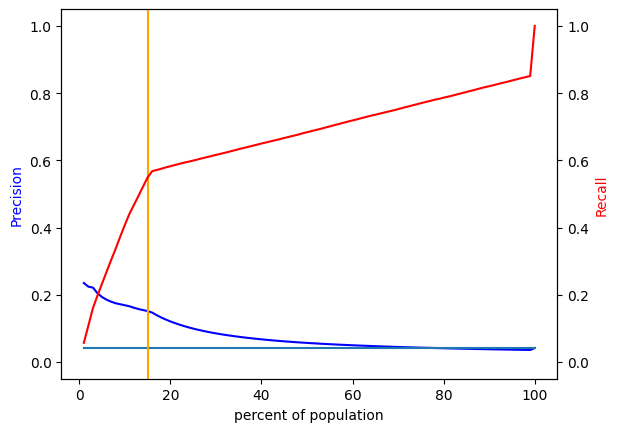

In [48]:
x = np.arange(1, 101)
y_precision = precision_b['stochastic_value']
y_recall = recall_b['stochastic_value']
y_baserate = recall_b['base_rate']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y_precision, 'b-')
ax1.plot(x, y_baserate)
ax2.plot(x, y_recall, 'r-')

ax1.set_xlabel('percent of population')
ax1.set_ylabel('Precision', color='b')
ax2.set_ylabel('Recall', color='r')
ax1.set_ylim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax1.axvline(x=15, ymin=0, ymax=1, color='orange')

#plt.savefig('PRk_curves/{date like 20221018}_{model_type}_{last 6 of exp hash}_{model_id}')
plt.savefig('PRk_curves/20221117_BaselineRank_86af5b_521')
plt.show()

# 16 Nov 2022
## Find the good models!

In [7]:
model_rank = pd.read_sql('''

select mg.model_type, m.model_id, avg(stochastic_value) as look_at_this
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
	left join triage_metadata.model_groups mg
		on (mg.model_group_id=m.model_group_id)
where em.experiment_hash = 'c627039efaabd76ef355e2868557d811'
	and metric = 'precision@'
	and parameter = '15_pct'
group by mg.model_type, m.model_id
order by look_at_this desc

''', db_engine)

model_rank

,model_type,model_id,look_at_this
0,triage.component.catwalk.estimators.classifier...,38,0.188989
1,triage.component.catwalk.baselines.rankers.Bas...,32,0.151174
2,triage.component.catwalk.baselines.rankers.Bas...,34,0.148590
3,triage.component.catwalk.baselines.rankers.Bas...,29,0.140766
4,triage.component.catwalk.baselines.rankers.Bas...,33,0.130520
5,triage.component.catwalk.baselines.rankers.Bas...,4,0.099816
6,triage.component.catwalk.baselines.rankers.Bas...,9,0.099356
7,triage.component.catwalk.baselines.rankers.Bas...,2,0.073041
8,triage.component.catwalk.baselines.rankers.Bas...,37,0.066074
9,triage.component.catwalk.baselines.rankers.Bas...,36,0.053895


## Baseline model
### Running queries

In [21]:
precision_b = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = 'c627039efaabd76ef355e2868557d811'
	and metric = 'precision@'
	and e.model_id = 32
order by parameter
  
""", db_engine)

recall_b = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = 'c627039efaabd76ef355e2868557d811'
	and metric = 'recall@'
	and e.model_id = 32
order by parameter

""", db_engine)

In [22]:
precision_b

,parameter,stochastic_value,model_id,base_rate
0,1,0.240328,32,0.041393
1,2,0.228454,32,0.041393
2,3,0.221733,32,0.041393
3,4,0.204639,32,0.041393
4,5,0.192612,32,0.041393
...,...,...,...,...
95,96,0.036233,32,0.041393
96,97,0.036020,32,0.041393
97,98,0.035799,32,0.041393
98,99,0.035573,32,0.041393


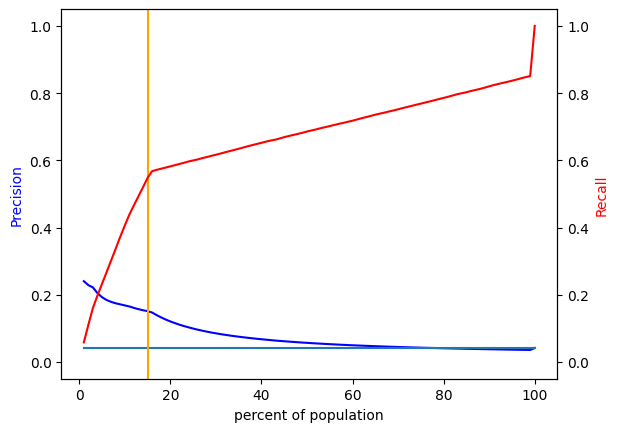

In [24]:
x = np.arange(1, 101, 1)
y_precision_b = precision_b['stochastic_value']
y_recall_b = recall_b['stochastic_value']
y_baserate_b = recall_b['base_rate']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y_precision_b, 'b-')
ax1.plot(x, y_baserate_b)
ax2.plot(x, y_recall_b, 'r-')

ax1.set_xlabel('percent of population')
ax1.set_ylabel('Precision', color='b')
ax2.set_ylabel('Recall', color='r')
ax1.set_ylim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax1.axvline(x=15, ymin=0, ymax=1, color='orange')

plt.show()
#plt.savefig('PRk_curves/{date like 20221018}_{model_type}.png')

## Our model
### Running queries

In [16]:
precision_ml_b = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = 'c627039efaabd76ef355e2868557d811'
	and metric = 'precision@'
	and e.model_id = 38
order by parameter
  
""", db_engine)

recall_ml = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = 'c627039efaabd76ef355e2868557d811'
	and metric = 'recall@'
	and e.model_id = 38
order by parameter

""", db_engine)

In [17]:
recall_ml

,parameter,stochastic_value,model_id,base_rate
0,1,0.085679,38,0.041393
1,2,0.176986,38,0.041393
2,3,0.264540,38,0.041393
3,4,0.340213,38,0.041393
4,5,0.394622,38,0.041393
...,...,...,...,...
95,96,1.000000,38,0.041393
96,97,1.000000,38,0.041393
97,98,1.000000,38,0.041393
98,99,1.000000,38,0.041393


### PR-k curve

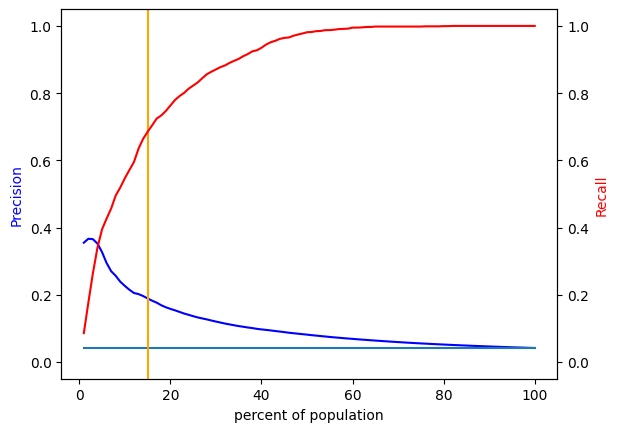

In [18]:
x = np.arange(1, 101)
y_precision = precision_ml['stochastic_value']
y_recall = recall_ml['stochastic_value']
y_baserate = recall_ml['base_rate']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y_precision, 'b-')
ax1.plot(x, y_baserate)
ax2.plot(x, y_recall, 'r-')

ax1.set_xlabel('percent of population')
ax1.set_ylabel('Precision', color='b')
ax2.set_ylabel('Recall', color='r')
ax1.set_ylim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax1.axvline(x=15, ymin=0, ymax=1, color='orange')

plt.show()
#plt.savefig('PRk_curves/{date like 20221018}_{model_type}.png')

# 6 Dec 2022
## Filling out Baseline Results slide for update

In [49]:
model_rank = pd.read_sql('''

select mg.model_type, m.model_id, avg(stochastic_value) as look_at_this
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
	left join triage_metadata.model_groups mg
		on (mg.model_group_id=m.model_group_id)
where em.experiment_hash = '8f00bc4fd7f00681b116a885813b81de'
	and metric = 'precision@'
	and parameter = '15_pct'
    and evaluation_start_time = '2015-12-30 00:00:00.000'
group by mg.model_type, m.model_id
order by look_at_this desc

''', db_engine)

model_rank

,model_type,model_id,look_at_this
0,sklearn.ensemble.RandomForestClassifier,4755,0.246243
1,sklearn.ensemble.RandomForestClassifier,4753,0.245881
2,sklearn.ensemble.RandomForestClassifier,4750,0.245700
3,sklearn.ensemble.RandomForestClassifier,4754,0.245519
4,sklearn.ensemble.RandomForestClassifier,4752,0.245338
...,...,...,...
123,triage.component.catwalk.baselines.rankers.Bas...,3884,0.045724
124,triage.component.catwalk.baselines.rankers.Bas...,3896,0.042936
125,sklearn.neural_network.MLPClassifier,4984,0.042797
126,triage.component.catwalk.baselines.rankers.Bas...,3897,0.032410


In [50]:
# Best models by category
model_rank.sort_values('look_at_this', ascending=False).groupby(
    'model_type', as_index=False
).head(1)

,model_type,model_id,look_at_this
0,sklearn.ensemble.RandomForestClassifier,4755,0.246243
25,sklearn.ensemble.AdaBoostClassifier,4808,0.243708
37,triage.component.catwalk.estimators.classifier...,3922,0.240268
78,sklearn.tree.DecisionTreeClassifier,3915,0.219808
87,triage.component.catwalk.baselines.rankers.Bas...,3903,0.173722
119,sklearn.neural_network.MLPClassifier,4986,0.046255


In [51]:
# Best baseline models for most recent year
model_rank[
    model_rank.model_type == 'triage.component.catwalk.baselines.rankers.BaselineRankMultiFeature'
].sort_values('look_at_this', ascending=False).head(5)

,model_type,model_id,look_at_this
87,triage.component.catwalk.baselines.rankers.Bas...,3903,0.173722
90,triage.component.catwalk.baselines.rankers.Bas...,3900,0.171145
92,triage.component.catwalk.baselines.rankers.Bas...,3904,0.159654
93,triage.component.catwalk.baselines.rankers.Bas...,3879,0.110266
94,triage.component.catwalk.baselines.rankers.Bas...,3875,0.108667


In [52]:
# Finding base rate
base_rate = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = '8f00bc4fd7f00681b116a885813b81de'
	and metric = 'precision@'
	and e.model_id in (3903, 3900, 3904)
    and cast(substring(parameter from '[0-9]+') as integer) = 15
order by stochastic_value desc
  
""", db_engine)

In [53]:
base_rate

,parameter,stochastic_value,model_id,base_rate
0,15,0.173722,3903,0.046766
1,15,0.171145,3900,0.046766
2,15,0.159654,3904,0.046766


In [39]:
# Finding precision for these models on previous validation dates
past_models = pd.read_sql("""

select cast(substring(parameter from '[0-9]+') as integer) as parameter, stochastic_value, e.model_id,
    cast(num_positive_labels as decimal(6,1))/cast(num_labeled_examples as decimal(6,1)) base_rate
from test_results.evaluations e
	left join triage_metadata.models m
		on (e.model_id=m.model_id)
	left join triage_metadata.experiment_models em
		on (em.model_hash=m.model_hash)
where em.experiment_hash = '8f00bc4fd7f00681b116a885813b81de'
	and metric = 'precision@'
	and hyperparameters = '{"rules": [{"feature": "progress_dummies_entity_id_all_bill_status_9_sum", "low_value_high_score": false}]}'
    and cast(substring(parameter from '[0-9]+') as integer) = 15
  
""", db_engine)

past_models

,parameter,stochastic_value,model_id,base_rate
0,15,0.196053,3539,0.048018
1,15,0.166797,3799,0.043555
2,15,0.208860,3643,0.052608
3,15,0.215061,3435,0.049648
4,15,0.201273,3487,0.047993
5,15,0.151162,4007,0.041393
6,15,0.177270,3955,0.046581
7,15,0.173722,3903,0.046766
8,15,0.191822,3695,0.048659
9,15,0.183006,3747,0.046143
